In [1]:
import numpy as np
import matplotlib.pyplot as plt

data    = np.genfromtxt("data-nonlinear.txt", delimiter=',')

class Model:
    def __init__(self):
        self.weight = np.zeros(16)
        self.bias = np.zeros(1)
        
    def __call__(self, x: np.ndarray):
        x = (self.weight * x).sum(axis=1, keepdims=True) + self.bias
        x = 1 / (1 + np.exp(-x)) 
        return x
    
    def __str__(self):
        return f'{self.weight}'

def BCELoss(pred: np.ndarray, label: np.ndarray):
    return -(label * np.log(pred) + (1 - label) * np.log(1 - pred)).mean(dtype=np.float64)

class LearningRate:
    def __init__(self, lr, epoch, step=0):
        self._lr = lr
        self._step = step
        self._epoch = epoch
        self._warming_epoch = epoch // 10
        self._not_warming_epoch = epoch - self._warming_epoch
    
    def item(self):
        if self._step < self._warming_epoch:
            lr = self._lr * (self._step / self._warming_epoch)
        else:
            lr = self._lr * (np.cos(np.pi * (self._step - self._warming_epoch) / self._not_warming_epoch) + 1)
            lr /= 2
        return lr
    
    def step(self):
        self._step += 1

In [2]:
def preprocess_data(data):
    transformed_data = data
    for i in range(2, 7):
        transformed_data = np.concatenate((transformed_data, data ** i), axis=1)

    for i in range(2):
        for j in range(2):
            transformed_data = np.concatenate((transformed_data, data[:, 0:1] ** i * data[:, 1:2] ** j), axis=1)
    return transformed_data


y_train = data[:, 2:3]
transformed_data = preprocess_data(data[:, 0:2])
transformed_data.shape

(118, 16)

In [3]:
from tqdm import tqdm

epoch = 400000
initial_lr = 1
max_acc = 0

lrs = []
losses = []
accuracys = []
weights = []
biases = []

learning_rate = LearningRate(initial_lr, epoch)
model = Model()

for step in tqdm(range(epoch)):
    # BCELoss
    loss: np.ndarray = BCELoss(model(transformed_data), y_train)
    preds = model(transformed_data) > 0.5
    acc = (preds == y_train).sum() / y_train.shape[0]
    max_acc = max(acc.item(), max_acc)
    
    # Save losses and parameters
    losses += [loss.tolist()]
    weights += [model.weight.tolist()]
    biases += [model.bias.tolist()]
    accuracys += [acc.item()]
    lrs += [learning_rate.item()]
    
    # Compute Error
    error = model(transformed_data) - y_train
    
    # Gradient Descent Algorithm
    temp_bias = model.bias - learning_rate.item() * error.mean()
    temp_weight = model.weight - learning_rate.item() * (error * transformed_data).mean(axis=0)
    
    # Update parameter
    model.bias = temp_bias
    model.weight = temp_weight
    
    learning_rate.step()

losses = np.asarray(losses)
weights = np.asarray(weights)
biases = np.asarray(biases)

print(f'Train step: {step}')
print(f'The optimal combination ratio: {model}')
print(f'Train loss: {loss:.4f}')
print(f'Train accuracy: {acc * 100:f}')
print(f'Max accuracy: {max_acc * 100:f}')

100%|████████████████████████████████████████████████████████████████████████| 400000/400000 [00:42<00:00, 9358.65it/s]


Train step: 399999
The optimal combination ratio: [  0.26070227   3.75966878 -11.36309159  -5.16708917  12.48347904
 -18.48758393  10.89988784  -9.4986995   -9.96225517  24.40790725
 -22.55920299  -5.80374766   2.24281555   3.75966878   0.26070227
  -7.11447104]
Train loss: 0.3211
Train accuracy: 87.288136
Max accuracy: 87.288136


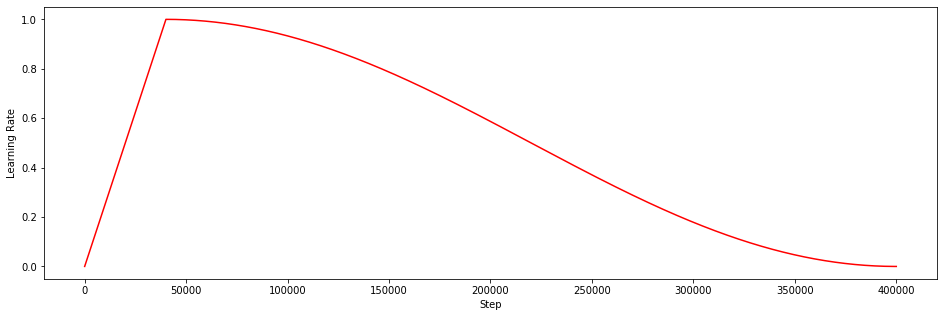

In [4]:
plt.figure(figsize=(16, 5))
plt.plot(lrs, c='r')
plt.ylabel('Learning Rate')
plt.xlabel('Step')
plt.show()

## 1. Plot the training data

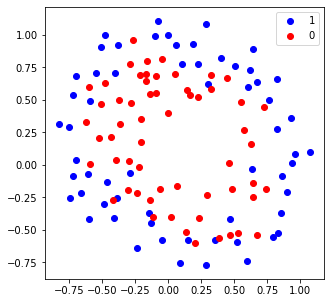

In [5]:
data    = np.genfromtxt("data-nonlinear.txt", delimiter=',')
pointX  = data[:, 0]
pointY  = data[:, 1]
label   = data[:, 2]

pointX0 = pointX[label == 0]
pointY0 = pointY[label == 0]

pointX1 = pointX[label == 1]
pointY1 = pointY[label == 1]

plt.figure(figsize=(5, 5))
plt.scatter(pointX0, pointY0, c='b', label=1)
plt.scatter(pointX1, pointY1, c='r', label=0)
plt.legend()
plt.show()

## 2. Write down the high dimensional function $g(x,y; \theta)$

$g(x,y; \theta) = \sum_{i=1}^{6} \theta_i x^i + \sum_{i=1}^{6} \theta_{6+i} y^i +  \theta_{13}x y +  \theta_{14}x^2 y  +  \theta_{15}x y^2 +  \theta_{16}x^2 y^2$

## 3. Plot the training error

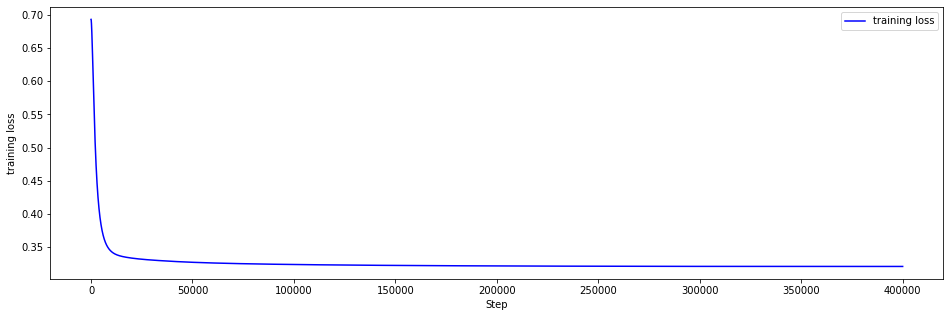

In [6]:
plt.figure(figsize=(16, 5))
plt.plot(losses, c='b', label='training loss')
plt.ylabel('training loss')
plt.xlabel('Step')
plt.legend(loc='upper right')
plt.show()

## 4. Plot the training accuracy  
## 5. Write down the final training accuracy

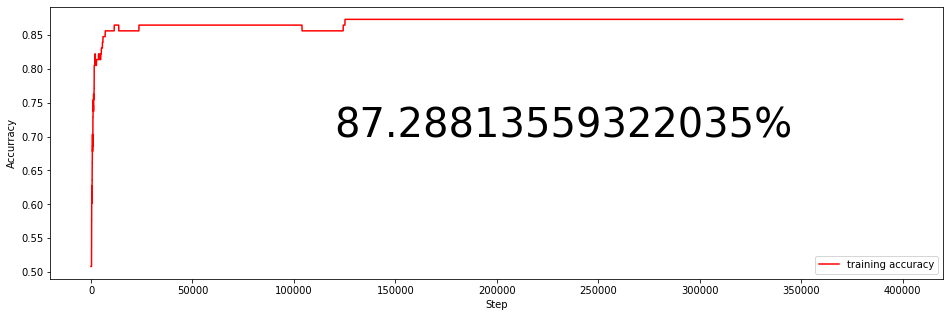

In [7]:
plt.figure(figsize=(16, 5))
plt.plot(accuracys, c='r', label='training accuracy')
plt.ylabel('Accurracy')
plt.xlabel('Step')
plt.text(len(accuracys) * 0.3, accuracys[-1] * 0.8, f'{accuracys[-1]*100}%', size=40)

plt.legend(loc='lower right')
plt.show()

**Final Training Accuracy is 87.28813559322035%**

## 6. Plot the optimal classifier superimposed on the training data

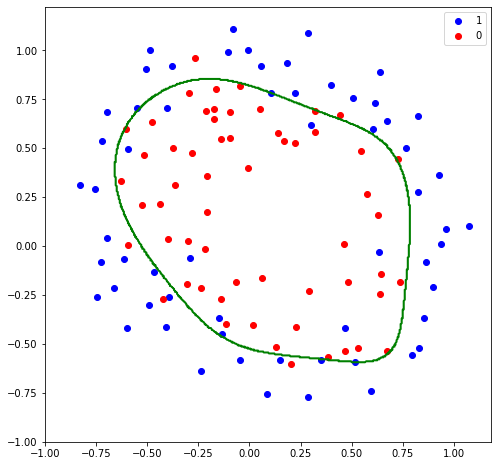

In [8]:
plt.figure(figsize=(8, 8))
plt.scatter(pointX0, pointY0, c='b', label=1)
plt.scatter(pointX1, pointY1, c='r', label=0)

x = np.arange(-1, 1, 0.005)
y = np.arange(-1, 1, 0.005)
data = np.array(np.meshgrid(x, y)).T.reshape(-1,2)
z = model(preprocess_data(data)) < 0.5
plt.tricontour(data[:, 0:1].squeeze(), data[:, 1:2].squeeze(), z.squeeze(), levels=1, colors='g')

plt.legend()
plt.show()